# Part 1: 무역 수출 서프라이즈 정의하기
- 과제 목표
- 과거 데이터를 기반으로 수출 실적이 예상 대비 얼마나 놀라운지를 측정하는 surprise 지표를 만듭니다. 이 지표는 이후 2, 3, 4번 과제의 핵심 입력값으로 사용됩니다.

In [ ]:
import os
base_path = r'C:\Users\PC2502\OneDrive\HSU\Singapore\presto-project'
data_path = os.path.join(base_path, 'data') 

In [2]:
# 데이터 로드 
import pandas as pd
import numpy as np

# 1. 수출 데이터 로드
export_value_data_path = os.path.join(data_path, 'export_value.csv')
export = pd.read_csv(export_value_data_path)
export['date'] = pd.to_datetime(export['date'])

print("=" * 80)
print("데이터 구조 확인")
print("=" * 80)
print(f"Shape: {export.shape}")
print(f"Columns: {export.columns.tolist()}")
print(f"Date range: {export['date'].min()} ~ {export['date'].max()}")
print(f"Unique symbols: {export['symbol'].nunique()}")
print(f"\n첫 5행:")
print(export.head())
print(f"\n기초 통계:")
print(export['export_value'].describe())

데이터 구조 확인
Shape: (22659, 3)
Columns: ['date', 'symbol', 'export_value']
Date range: 2020-01-31 00:00:00 ~ 2025-10-31 00:00:00
Unique symbols: 349

첫 5행:
        date  symbol  export_value
0 2020-01-31  ZPWVVS       2865954
1 2020-01-31  YRTSYY      10836746
2 2020-01-31  OOVKZQ     861314197
3 2020-01-31  DKEETE      16163843
4 2020-01-31  AUBZAL       2657843

기초 통계:
count    2.265900e+04
mean     5.734279e+07
std      2.867482e+08
min      3.000000e+00
25%      2.172296e+06
50%      6.060556e+06
75%      1.572149e+07
max      5.725632e+09
Name: export_value, dtype: float64


In [ ]:
def calculate_growth_rates(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    
    df = df.sort_values(['symbol', 'date'])
    
    # 성장률 계산 (결측값을 10^-16로 대체)
    SMALL_VALUE = 1e-16
    
    df['export_value_lag12'] = df.groupby('symbol')['export_value'].shift(12)
    df['yoy'] = (df['export_value'] - df['export_value_lag12']) / df['export_value_lag12']
    df['yoy'] = df['yoy'].fillna(SMALL_VALUE)
    
    df['quarter_avg'] = df.groupby(['symbol', 'year', 'quarter'])['export_value'].transform('mean')
    df['quarter_avg_lag1'] = df.groupby('symbol')['quarter_avg'].shift(1)
    df['qoq'] = (df['quarter_avg'] - df['quarter_avg_lag1']) / df['quarter_avg_lag1']
    df['qoq'] = df['qoq'].fillna(SMALL_VALUE)
    
    df['export_value_lag1'] = df.groupby('symbol')['export_value'].shift(1)
    df['mom'] = (df['export_value'] - df['export_value_lag1']) / df['export_value_lag1']
    df['mom'] = df['mom'].fillna(SMALL_VALUE)
    
    # 결측값 처리 정보 출력
    print("\n=== 결측값 처리 완료 (10^-16로 대체) ===")
    print(f"YoY: {(df['yoy'] == SMALL_VALUE).sum()} 개 결측값 대체")
    print(f"QoQ: {(df['qoq'] == SMALL_VALUE).sum()} 개 결측값 대체")
    print(f"MoM: {(df['mom'] == SMALL_VALUE).sum()} 개 결측값 대체")
    
    return df


In [4]:
# 사용
export = calculate_growth_rates(export)

export_with_yoy = export[export['yoy'].notna()]


=== 결측값 처리 완료 (10^-16로 대체) ===
YoY: 4157 개 결측값 대체
QoQ: 349 개 결측값 대체
MoM: 349 개 결측값 대체


In [ ]:
print("\n방법 2 - groupby 후 선택:")
result2 = export.groupby('symbol')['yoy'].mean()['AEGQRD']
print(result2)



방법 2 - groupby 후 선택:
1.1519591580406


## Step 2: Surprise 개념 이해하기

**Surprise란?**
- "실제 발표된 값이 시장의 예상치와 얼마나 다른지"를 의미
- 단순히 수출액이 높다 ≠ Surprise
- **예상과 달랐을 때** = 진짜 Surprise!

**핵심 개념:**
- Positive Surprise: 예상보다 훨씬 좋은 실적
- Negative Surprise: 예상보다 나쁜 실적
- 주식 시장은 "평균적인 성장"을 이미 주가에 반영
- **예상과의 차이**가 새로운 정보 → 주가 변동

**목표:**
"평소 패턴 대비 얼마나 이례적인가"를 수치화

## Step 3: 전체 기간 Z-Score 계산하기

**Z-Score 공식:** `z = (x - μ) / σ`
- x: 관측값 (예: 이번 달 YoY)
- μ: 평균 (과거 YoY의 평균)
- σ: 표준편차 (과거 YoY의 표준편차)

**해석:**
- Z-Score = 0: 정확히 평균
- Z-Score = 1: 평균보다 1 표준편차 위 (상위 16%)
- Z-Score = 2: 상위 2.5% (매우 이례적)
- Z-Score = 3: 상위 0.1% (극히 드문 사건)

**왜 사용하나?**
서로 다른 기업을 공정하게 비교하기 위해 (각 기업의 "평소 패턴" 고려)


In [6]:
# Step 3: 전체 기간 Z-Score 계산
import matplotlib.pyplot as plt

# 각 기업별로 전체 기간 평균과 표준편차를 계산하여 Z-Score 구하기
def calculate_zscore(df, column):
    """기업별 전체 기간 Z-Score 계산"""
    # 기업별 평균과 표준편차
    group_mean = df.groupby('symbol')[column].transform('mean')
    group_std = df.groupby('symbol')[column].transform('std')
    
    # 표준편차가 0이면 10^-16로 대체
    group_std = group_std.replace(0, 1e-16)
    
    # Z-Score 계산
    zscore = (df[column] - group_mean) / group_std
    
    return zscore

# YoY, QoQ, MoM에 대해 Z-Score 계산
export['zscore_yoy'] = calculate_zscore(export, 'yoy')
export['zscore_qoq'] = calculate_zscore(export, 'qoq')
export['zscore_mom'] = calculate_zscore(export, 'mom')

print("=" * 80)
print("전체 기간 Z-Score 기초 통계")
print("=" * 80)
print("\nYoY Z-Score:")
print(export['zscore_yoy'].describe())
print(f"\n|Z-Score| > 2인 비율: {(export['zscore_yoy'].abs() > 2).sum() / export['zscore_yoy'].notna().sum() * 100:.2f}%")
print(f"이론적 비율: ~5%")

print("\n" + "=" * 80)
print("극단적 Surprise 사례 (YoY 기준)")
print("=" * 80)
print("\nTop 10 Positive Surprises:")
top_surprises = export.nlargest(10, 'zscore_yoy')[['date', 'symbol', 'yoy', 'zscore_yoy']]
print(top_surprises.to_string(index=False))

print("\nTop 10 Negative Surprises:")
bottom_surprises = export.nsmallest(10, 'zscore_yoy')[['date', 'symbol', 'yoy', 'zscore_yoy']]
print(bottom_surprises.to_string(index=False))


전체 기간 Z-Score 기초 통계

YoY Z-Score:
count    2.265800e+04
mean    -3.998332e-18
std      9.917789e-01
min     -2.843120e+00
25%     -4.928277e-01
50%     -2.152252e-01
75%      2.113199e-01
max      8.247076e+00
Name: zscore_yoy, dtype: float64

|Z-Score| > 2인 비율: 4.59%
이론적 비율: ~5%

극단적 Surprise 사례 (YoY 기준)

Top 10 Positive Surprises:
      date symbol           yoy  zscore_yoy
2022-05-31 OUKEEB 768983.929487    8.247076
2023-10-31 JYFXNM  27803.851216    8.234449
2021-02-28 IMYNMI  40245.852941    8.185453
2021-04-30 DUYYKV     26.401451    8.161588
2021-02-28 XNXMBG    144.274382    8.155483
2025-10-31 IOPEDG     40.594335    8.046530
2024-07-31 GQQMUO    707.513942    8.033807
2023-06-30 YCDYBQ   1212.949601    8.018485
2021-06-30 VFVAXC     41.907328    7.901331
2023-01-31 OCDYNK    144.037085    7.875079

Top 10 Negative Surprises:
      date symbol       yoy  zscore_yoy
2023-01-31 DHMCLM -0.900602   -2.843120
2023-02-28 DHMCLM -0.849452   -2.680051
2023-07-31 RYCFCX -0.401570   -2.

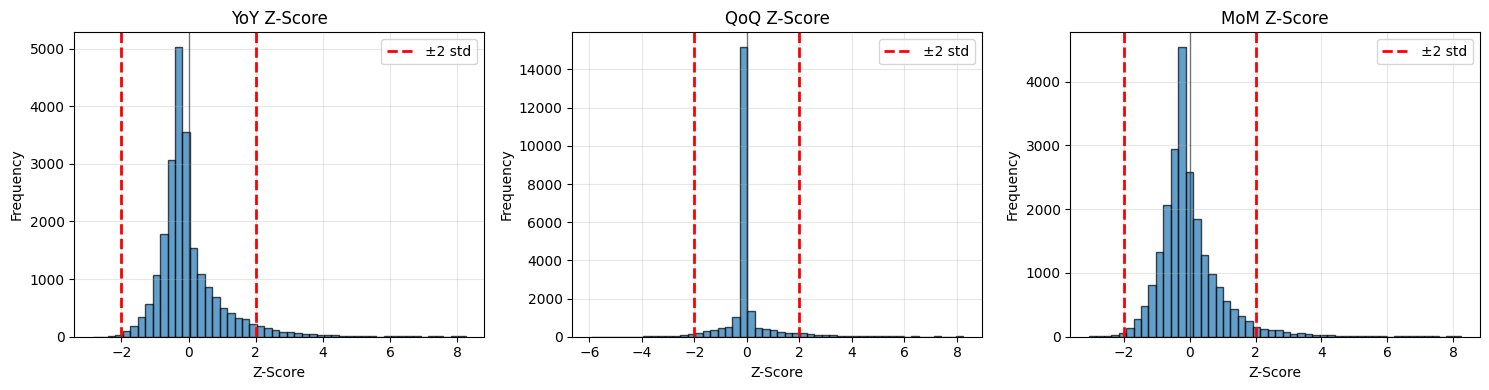

Z-Score 분포 그래프 저장: zscore_distribution.png


In [7]:
# Z-Score 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (col, title) in enumerate([('zscore_yoy', 'YoY Z-Score'), 
                                       ('zscore_qoq', 'QoQ Z-Score'), 
                                       ('zscore_mom', 'MoM Z-Score')]):
    ax = axes[idx]
    data = export[col].dropna()
    # 무한대 값 제거
    data = data[np.isfinite(data)]
    
    # 히스토그램
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    
    # ±2 표준편차 선
    ax.axvline(-2, color='red', linestyle='--', linewidth=2, label='±2 std')
    ax.axvline(2, color='red', linestyle='--', linewidth=2)
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Z-Score')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'zscore_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Z-Score 분포 그래프 저장: zscore_distribution.png")


## Step 4: Rolling Window - Forward-Looking Bias 해결

**문제점: 전체 기간 Z-Score의 치명적 결함**
- 미래 정보를 사용함 (Look-Ahead Bias)
- 2022년 6월의 Z-Score 계산 시 2024년 데이터까지 사용 → 현실 불가능
- 백테스트 결과가 실제와 괴리됨

**해결책: Rolling Window**
- 특정 시점의 Z-Score 계산 시, **그 시점까지의 과거 데이터만** 사용
- "움직이는 창문"처럼 작동

**Trade-off:**
- 짧은 window (12개월): 빠른 반응, 불안정한 추정
- 긴 window (36개월): 안정적, 느린 반응, 많은 데이터 손실

**권장: 24개월 Rolling Window**
1. 계절성을 2회 포함 → 안정적 패턴 추정
2. 최근 2년 트렌드 반영
3. YoY는 12개월 차이이므로, 24개월이면 최소 2개의 YoY 비교 가능


## Step 5: Rolling Z-Score 계산 (진짜 Surprise 지표!)

**Rolling의 의미:**
- 2023년 6월 Z-Score = 2021년 7월 ~ 2023년 6월 (24개월) 데이터만 사용
- 2023년 7월 Z-Score = 2021년 8월 ~ 2023년 7월 (24개월) 데이터만 사용
- 각 시점에서 "그때 사용 가능했던 정보"만 활용


In [8]:
# Step 5: Rolling Z-Score 계산 (최종 Surprise 지표)

def calculate_rolling_zscore(df, column, window=24, min_periods=1):
    """
    Rolling Z-Score 계산 (Forward-Looking Bias 방지)
    
    Parameters:
    - df: DataFrame
    - column: Z-Score를 계산할 컬럼
    - window: Rolling window 크기 (개월 수)
    - min_periods: 최소 필요 데이터 포인트 수
    
    Returns:
    - Rolling Z-Score Series
    """
    # 결과를 저장할 Series 생성
    rolling_zscore = pd.Series(index=df.index, dtype=float)
    
    # 기업별로 처리
    for symbol in df['symbol'].unique():
        # 해당 기업 데이터만 추출 (날짜순 정렬)
        mask = df['symbol'] == symbol
        symbol_data = df.loc[mask].sort_values('date')
        
        # 해당 컬럼의 데이터
        values = symbol_data[column]
        
        # Rolling mean과 std 계산
        rolling_mean = values.rolling(window=window, min_periods=min_periods).mean()
        rolling_std = values.rolling(window=window, min_periods=min_periods).std()
        
        # Z-Score 계산: (현재값 - rolling평균) / rolling표준편차
        # std가 0이면 10^-16로 대체
        rolling_std = rolling_std.replace(0, 1e-16)
        zscore = (values - rolling_mean) / rolling_std
        
        # 결과 저장
        rolling_zscore.loc[symbol_data.index] = zscore
    
    return rolling_zscore


def calculate_adaptive_rolling_zscore(df, column, max_window=24, min_periods=1):
    """
    가변 윈도우 Rolling Z-Score 계산 (Forward-Looking Bias 방지)
    
    각 시점에서 사용 가능한 데이터 포인트만 사용 (최대 max_window개월까지)
    - 예: 5개월 데이터만 있으면 5개월 윈도우 사용
    - 예: 25개월 데이터 있으면 24개월 윈도우 사용 (max_window=24)
    
    Parameters:
    - df: DataFrame
    - column: Z-Score를 계산할 컬럼
    - max_window: 최대 윈도우 크기 (개월 수)
    - min_periods: 최소 필요 데이터 포인트 수
    
    Returns:
    - Rolling Z-Score Series
    """
    # 결과를 저장할 Series 생성
    rolling_zscore = pd.Series(index=df.index, dtype=float)
    
    # 기업별로 처리
    for symbol in df['symbol'].unique():
        # 해당 기업 데이터만 추출 (날짜순 정렬)
        mask = df['symbol'] == symbol
        symbol_data = df.loc[mask].sort_values('date').reset_index(drop=False)
        
        # 해당 컬럼의 데이터
        values = symbol_data[column].values
        original_indices = symbol_data['index'].values
        
        # 각 시점에 대해 가변 윈도우 적용
        zscores = []
        for i in range(len(values)):
            # 사용 가능한 데이터 포인트 수 (현재 포함)
            available_points = i + 1
            
            # 실제 사용할 윈도우 크기 (최소 min_periods, 최대 max_window)
            effective_window = min(available_points, max_window)
            
            if available_points < min_periods:
                # 최소 데이터 포인트가 없으면 NaN
                zscores.append(np.nan)
            else:
                # 윈도우 범위의 데이터 추출
                start_idx = max(0, i - effective_window + 1)
                window_values = values[start_idx:i+1]
                
                # 평균과 표준편차 계산
                window_mean = np.mean(window_values)
                window_std = np.std(window_values, ddof=1)  # 표본 표준편차
                
                # 표준편차가 0이면 10^-16으로 대체
                if window_std == 0 or np.isnan(window_std):
                    window_std = 1e-16
                
                # Z-Score 계산
                zscore = (values[i] - window_mean) / window_std
                zscores.append(zscore)
        
        # 결과 저장 (원래 인덱스에 맞춰서)
        rolling_zscore.loc[original_indices] = zscores
    
    return rolling_zscore


print("=" * 80)
print("Rolling Z-Score 계산 시작 (가변 윈도우: 1~24개월)")
print("=" * 80)

# YoY, QoQ, MoM에 대해 1~24개월 Rolling Z-Score 계산
window_sizes = range(1, 25)

for window_size in window_sizes:
    # YoY
    col_name = f'rolling_zscore_yoy_w{window_size}'
    export[col_name] = calculate_rolling_zscore(export, 'yoy', window=window_size)
    
    # QoQ
    col_name = f'rolling_zscore_qoq_w{window_size}'
    export[col_name] = calculate_rolling_zscore(export, 'qoq', window=window_size)
    
    # MoM
    col_name = f'rolling_zscore_mom_w{window_size}'
    export[col_name] = calculate_rolling_zscore(export, 'mom', window=window_size)
    
    print(f"Window {window_size:2d}개월 Rolling Z-Score 계산 완료")

# 기존 호환성을 위해 24개월 버전을 기본으로 복사
export['rolling_zscore_yoy'] = export['rolling_zscore_yoy_w24']
export['rolling_zscore_qoq'] = export['rolling_zscore_qoq_w24']
export['rolling_zscore_mom'] = export['rolling_zscore_mom_w24']

# 가변 윈도우 적용 (사용 가능한 데이터만 사용, 최대 24개월)
print("\n" + "=" * 80)
print("적응형 Rolling Z-Score 계산 시작 (가변 윈도우: 최대 24개월)")
print("=" * 80)

export['adaptive_rolling_zscore_yoy'] = calculate_adaptive_rolling_zscore(export, 'yoy', max_window=24)
export['adaptive_rolling_zscore_qoq'] = calculate_adaptive_rolling_zscore(export, 'qoq', max_window=24)
export['adaptive_rolling_zscore_mom'] = calculate_adaptive_rolling_zscore(export, 'mom', max_window=24)

print("✓ 적응형 Rolling Z-Score 계산 완료")
print("\n설명: 각 시점에서 사용 가능한 최대 데이터(최대 24개월)만 사용")
print("  - 예: 5개월 데이터만 있으면 → 5개월 윈도우 사용")
print("  - 예: 25개월 이상 데이터 있으면 → 24개월 윈도우 사용")

print("\n" + "=" * 80)
print("Rolling Z-Score 기초 통계 (24개월 윈도우)")
print("=" * 80)
print("\nYoY Rolling Z-Score:")
print(export['rolling_zscore_yoy'].describe())
print(f"결측치: {export['rolling_zscore_yoy'].isna().sum()} / {len(export)}")
print(f"|Z-Score| > 2인 비율: {(export['rolling_zscore_yoy'].abs() > 2).sum() / export['rolling_zscore_yoy'].notna().sum() * 100:.2f}%")


Rolling Z-Score 계산 시작 (가변 윈도우: 1~24개월)
Window  1개월 Rolling Z-Score 계산 완료
Window  2개월 Rolling Z-Score 계산 완료
Window  3개월 Rolling Z-Score 계산 완료
Window  4개월 Rolling Z-Score 계산 완료
Window  5개월 Rolling Z-Score 계산 완료
Window  6개월 Rolling Z-Score 계산 완료
Window  7개월 Rolling Z-Score 계산 완료
Window  8개월 Rolling Z-Score 계산 완료
Window  9개월 Rolling Z-Score 계산 완료
Window 10개월 Rolling Z-Score 계산 완료
Window 11개월 Rolling Z-Score 계산 완료
Window 12개월 Rolling Z-Score 계산 완료
Window 13개월 Rolling Z-Score 계산 완료
Window 14개월 Rolling Z-Score 계산 완료
Window 15개월 Rolling Z-Score 계산 완료
Window 16개월 Rolling Z-Score 계산 완료
Window 17개월 Rolling Z-Score 계산 완료
Window 18개월 Rolling Z-Score 계산 완료
Window 19개월 Rolling Z-Score 계산 완료
Window 20개월 Rolling Z-Score 계산 완료
Window 21개월 Rolling Z-Score 계산 완료
Window 22개월 Rolling Z-Score 계산 완료
Window 23개월 Rolling Z-Score 계산 완료
Window 24개월 Rolling Z-Score 계산 완료

적응형 Rolling Z-Score 계산 시작 (가변 윈도우: 최대 24개월)


C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_me

✓ 적응형 Rolling Z-Score 계산 완료

설명: 각 시점에서 사용 가능한 최대 데이터(최대 24개월)만 사용
  - 예: 5개월 데이터만 있으면 → 5개월 윈도우 사용
  - 예: 25개월 이상 데이터 있으면 → 24개월 윈도우 사용

Rolling Z-Score 기초 통계 (24개월 윈도우)

YoY Rolling Z-Score:
count    22310.000000
mean         0.075891
std          1.172381
min         -3.691115
25%         -0.599868
50%          0.000000
75%          0.393362
max          4.694855
Name: rolling_zscore_yoy, dtype: float64
결측치: 349 / 22659
|Z-Score| > 2인 비율: 9.71%


C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\PC2502\Anaconda3\envs\jup\Lib\site-packages\numpy\_core\_me

In [9]:
# 적응형 Rolling Z-Score 검증
print("=" * 80)
print("적응형 Rolling Z-Score 검증")
print("=" * 80)

# 특정 심볼 선택하여 검증
test_symbol = 'AEGQRD'
test_data = export[export['symbol'] == test_symbol].sort_values('date').reset_index(drop=True)

print(f"\n테스트 심볼: {test_symbol}")
print(f"총 데이터 포인트: {len(test_data)}")

# 처음 몇 개의 데이터 포인트에서 윈도우 크기 확인
print("\n처음 5개 데이터 포인트의 적응형 Z-Score:")
print("(초기에는 사용 가능한 데이터가 적으므로 작은 윈도우 사용)")
for i in range(min(5, len(test_data))):
    row = test_data.iloc[i]
    adaptive_zscore = row['adaptive_rolling_zscore_yoy']
    print(f"  {i+1}번째 데이터 (날짜: {row['date']}): Z-Score = {adaptive_zscore:.4f}")

# 24번째 이후 데이터 포인트 확인
print("\n24번째 이후 데이터 포인트 (24개월 윈도우 사용):")
if len(test_data) >= 26:
    for i in range(24, min(27, len(test_data))):
        row = test_data.iloc[i]
        adaptive_zscore = row['adaptive_rolling_zscore_yoy']
        fixed_24m_zscore = row['rolling_zscore_yoy_w24']
        print(f"  {i+1}번째 데이터 (날짜: {row['date']}): "
              f"Adaptive = {adaptive_zscore:.4f}, Fixed 24M = {fixed_24m_zscore:.4f}")

# 적응형과 고정 24개월 윈도우 비교
print("\n" + "=" * 80)
print("적응형 vs 고정 24개월 윈도우 비교")
print("=" * 80)
print("\n24번째 이후에는 적응형과 고정 24개월이 동일해야 합니다.")

# 24번째 이후 데이터에서 차이 확인
if len(test_data) >= 25:
    diff_data = test_data.iloc[24:].copy()
    diff_data['diff'] = (diff_data['adaptive_rolling_zscore_yoy'] - 
                         diff_data['rolling_zscore_yoy_w24']).abs()
    max_diff = diff_data['diff'].max()
    mean_diff = diff_data['diff'].mean()
    
    print(f"최대 차이: {max_diff:.10f}")
    print(f"평균 차이: {mean_diff:.10f}")
    
    if max_diff < 1e-6:
        print("✓ 검증 성공! 24번째 이후 데이터에서 적응형과 고정 24개월 윈도우가 일치합니다.")
    else:
        print("⚠ 주의: 약간의 차이가 있습니다. (수치 오차 가능)")

# 전체 통계
print("\n" + "=" * 80)
print("적응형 Rolling Z-Score 전체 통계")
print("=" * 80)
for col in ['adaptive_rolling_zscore_yoy', 'adaptive_rolling_zscore_qoq', 'adaptive_rolling_zscore_mom']:
    data = export[col].dropna()
    extreme = (data.abs() > 2).sum()
    extreme_pct = extreme / len(data) * 100 if len(data) > 0 else 0
    print(f"\n{col}:")
    print(f"  데이터 포인트: {len(data):,}")
    print(f"  평균: {data.mean():.4f}")
    print(f"  표준편차: {data.std():.4f}")
    print(f"  |Z-Score| > 2: {extreme:,} ({extreme_pct:.2f}%)")
    print(f"  최댓값: {data.max():.4f}")
    print(f"  최솟값: {data.min():.4f}")


적응형 Rolling Z-Score 검증

테스트 심볼: AEGQRD
총 데이터 포인트: 70

처음 5개 데이터 포인트의 적응형 Z-Score:
(초기에는 사용 가능한 데이터가 적으므로 작은 윈도우 사용)
  1번째 데이터 (날짜: 2020-01-31 00:00:00): Z-Score = 0.0000
  2번째 데이터 (날짜: 2020-02-29 00:00:00): Z-Score = 0.0000
  3번째 데이터 (날짜: 2020-03-31 00:00:00): Z-Score = 0.0000
  4번째 데이터 (날짜: 2020-04-30 00:00:00): Z-Score = 0.0000
  5번째 데이터 (날짜: 2020-05-31 00:00:00): Z-Score = -0.8944

24번째 이후 데이터 포인트 (24개월 윈도우 사용):
  25번째 데이터 (날짜: 2022-01-31 00:00:00): Adaptive = 3.3924, Fixed 24M = 3.3924
  26번째 데이터 (날짜: 2022-02-28 00:00:00): Adaptive = 1.9196, Fixed 24M = 1.9196
  27번째 데이터 (날짜: 2022-03-31 00:00:00): Adaptive = 0.2412, Fixed 24M = 0.2412

적응형 vs 고정 24개월 윈도우 비교

24번째 이후에는 적응형과 고정 24개월이 동일해야 합니다.
최대 차이: 0.0000000000
평균 차이: 0.0000000000
✓ 검증 성공! 24번째 이후 데이터에서 적응형과 고정 24개월 윈도우가 일치합니다.

적응형 Rolling Z-Score 전체 통계

adaptive_rolling_zscore_yoy:
  데이터 포인트: 22,659
  평균: -0.0106
  표준편차: 1.1993
  |Z-Score| > 2: 2,167 (9.56%)
  최댓값: 4.6949
  최솟값: -3.6911

adaptive_rolling_zscore_qoq:
  데이터 포인트: 22

C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\3171326254.py:31: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\3171326254.py:31: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\3171326254.py:31: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\3171326254.py:32: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(base_path, 'rolling_zscore_timeseries.png'), dpi=150, bbox_inches='tight')
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\3171326254.py:32: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(base_path, 'rolling_zscore_timeseries.png'), d

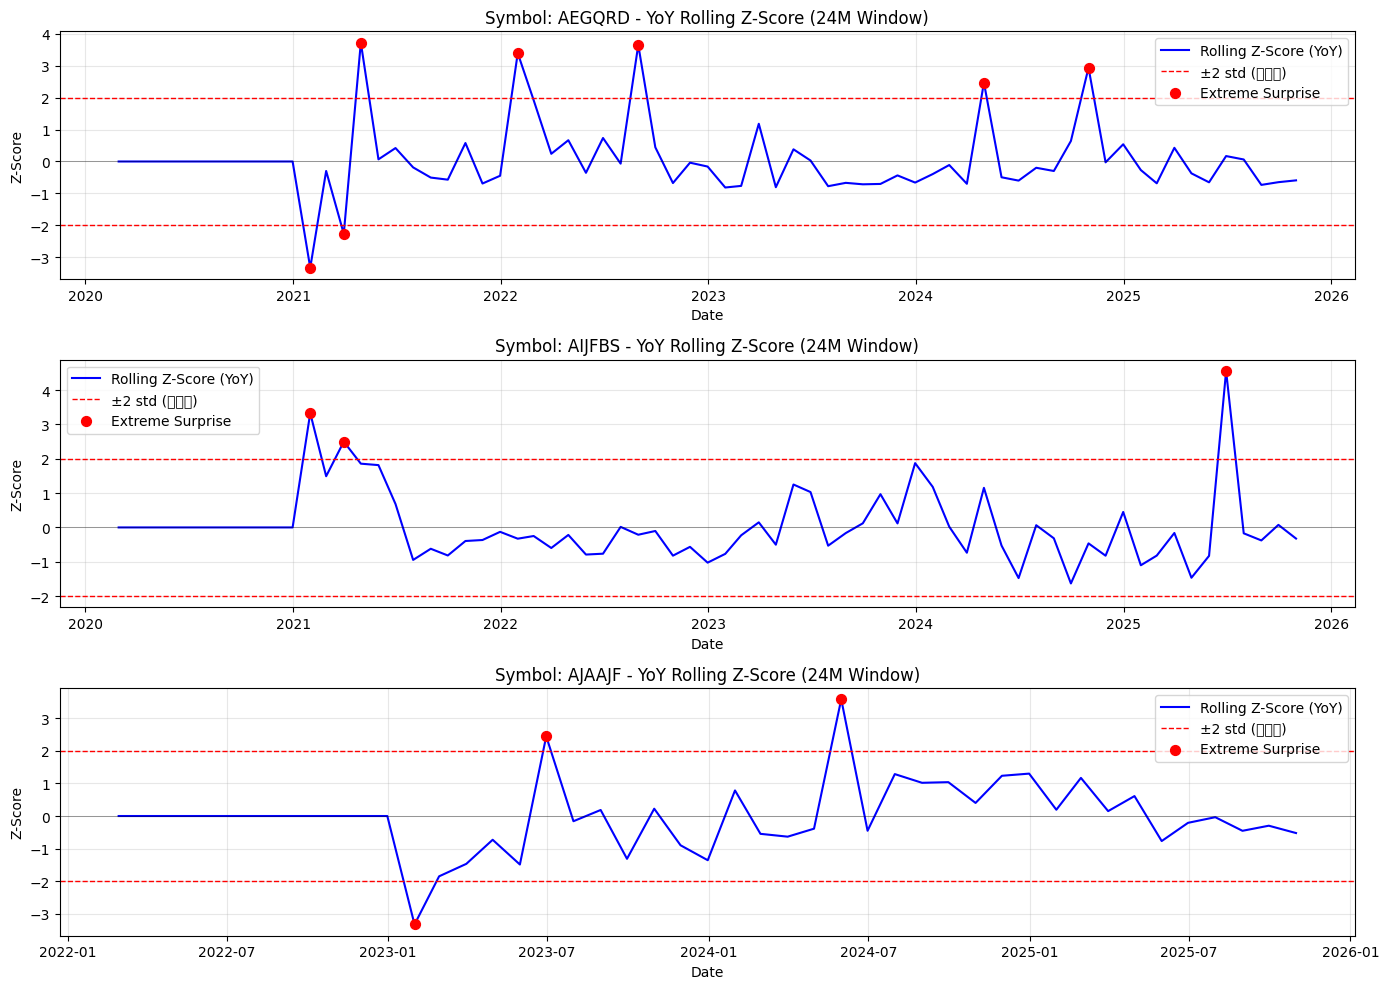

Rolling Z-Score 시계열 그래프 저장: rolling_zscore_timeseries.png


In [10]:
# Rolling Z-Score 시계열 시각화 (샘플 기업)
# 무작위로 3개 기업 선택
sample_symbols = export['symbol'].unique()[:3]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, symbol in enumerate(sample_symbols):
    ax = axes[idx]
    symbol_data = export[export['symbol'] == symbol].sort_values('date')
    
    # Rolling Z-Score 플롯
    ax.plot(symbol_data['date'], symbol_data['rolling_zscore_yoy'], 
            linewidth=1.5, label='Rolling Z-Score (YoY)', color='blue')
    
    # ±2 표준편차 선
    ax.axhline(2, color='red', linestyle='--', linewidth=1, label='±2 std (이상치)')
    ax.axhline(-2, color='red', linestyle='--', linewidth=1)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # 이상치 강조
    outliers = symbol_data[symbol_data['rolling_zscore_yoy'].abs() > 2]
    ax.scatter(outliers['date'], outliers['rolling_zscore_yoy'], 
               color='red', s=50, zorder=5, label='Extreme Surprise')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Z-Score')
    ax.set_title(f'Symbol: {symbol} - YoY Rolling Z-Score (24M Window)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'rolling_zscore_timeseries.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Rolling Z-Score 시계열 그래프 저장: rolling_zscore_timeseries.png")


C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\174864417.py:32: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\174864417.py:32: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\174864417.py:32: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\174864417.py:32: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\174864417.py:32: UserWarning: Glyph 51080 (\N{HANGUL SYLLABLE ISS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_4264\174864417.py:32: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(

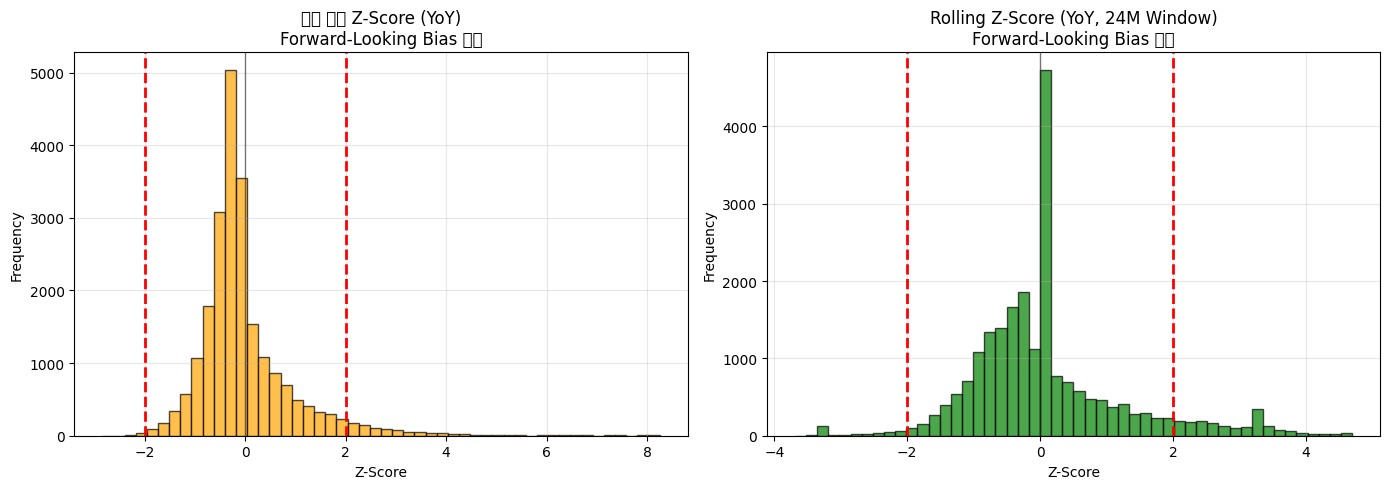

Z-Score 비교 그래프 저장: zscore_comparison.png


In [11]:
# 전체 기간 Z-Score vs Rolling Z-Score 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 전체 기간 Z-Score
ax = axes[0]
data = export['zscore_yoy'].dropna()
# 무한대 값 제거
data = data[np.isfinite(data)]
ax.hist(data, bins=50, alpha=0.7, edgecolor='black', color='orange')
ax.axvline(-2, color='red', linestyle='--', linewidth=2)
ax.axvline(2, color='red', linestyle='--', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Z-Score')
ax.set_ylabel('Frequency')
ax.set_title('전체 기간 Z-Score (YoY)\nForward-Looking Bias 있음')
ax.grid(True, alpha=0.3)

# Rolling Z-Score
ax = axes[1]
data = export['rolling_zscore_yoy'].dropna()
# 무한대 값 제거
data = data[np.isfinite(data)]
ax.hist(data, bins=50, alpha=0.7, edgecolor='black', color='green')
ax.axvline(-2, color='red', linestyle='--', linewidth=2)
ax.axvline(2, color='red', linestyle='--', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Z-Score')
ax.set_ylabel('Frequency')
ax.set_title('Rolling Z-Score (YoY, 24M Window)\nForward-Looking Bias 제거')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'zscore_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Z-Score 비교 그래프 저장: zscore_comparison.png")


In [12]:
# Forward-Looking Bias 검증
# 특정 날짜를 선택하여 수동 계산과 비교
test_symbol = export['symbol'].iloc[500]
test_date_idx = 35  # 충분한 과거 데이터가 있는 시점
test_window_size = 24  # 검증용 윈도우 크기

symbol_data = export[export['symbol'] == test_symbol].sort_values('date').reset_index(drop=True)

if len(symbol_data) > test_date_idx + test_window_size:
    test_date = symbol_data.loc[test_date_idx, 'date']
    test_value = symbol_data.loc[test_date_idx, 'yoy']
    calculated_zscore = symbol_data.loc[test_date_idx, f'rolling_zscore_yoy_w{test_window_size}']
    
    # 수동 계산: 과거 24개월 데이터만 사용
    past_24_months = symbol_data.loc[test_date_idx-test_window_size+1:test_date_idx, 'yoy']
    manual_mean = past_24_months.mean()
    manual_std = past_24_months.std()
    manual_zscore = (test_value - manual_mean) / manual_std
    
    print("=" * 80)
    print("Forward-Looking Bias 검증")
    print("=" * 80)
    print(f"테스트 기업: {test_symbol}")
    print(f"테스트 날짜: {test_date}")
    print(f"YoY 값: {test_value:.4f}")
    print(f"\n과거 24개월 통계:")
    print(f"  평균: {manual_mean:.4f}")
    print(f"  표준편차: {manual_std:.4f}")
    print(f"\n프로그램 계산 Z-Score: {calculated_zscore:.4f}")
    print(f"수동 계산 Z-Score: {manual_zscore:.4f}")
    print(f"차이: {abs(calculated_zscore - manual_zscore):.6f}")
    
    if abs(calculated_zscore - manual_zscore) < 0.001:
        print("\n검증 성공! Forward-Looking Bias가 없습니다.")
    else:
        print("\n경고: 차이가 있습니다. 코드를 다시 확인하세요.")
else:
    print("검증을 위한 충분한 데이터가 없습니다.")


Forward-Looking Bias 검증
테스트 기업: ASANPU
테스트 날짜: 2022-12-31 00:00:00
YoY 값: 0.0809

과거 24개월 통계:
  평균: 0.3308
  표준편차: 0.2940

프로그램 계산 Z-Score: -0.8498
수동 계산 Z-Score: -0.8498
차이: 0.000000

검증 성공! Forward-Looking Bias가 없습니다.


## Step 7: 최종 데이터 저장

**중요:** 이 파일이 Part 2, 3, 4의 입력 데이터가 됩니다!


In [13]:
# Step 7: 최종 데이터 저장

# 저장할 컬럼 선택
base_columns = [
    'date',
    'symbol',
    'export_value',
    'yoy', 'qoq', 'mom',  # 성장률
]

# 가변 윈도우 rolling z-score 컬럼 추가 (1~24개월)
window_columns = []
for window_size in range(1, 25):
    window_columns.extend([
        f'rolling_zscore_yoy_w{window_size}',
        f'rolling_zscore_qoq_w{window_size}',
        f'rolling_zscore_mom_w{window_size}'
    ])

# 기본 rolling z-score 컬럼 추가 (24개월 기본값)
window_columns.extend([
    'rolling_zscore_yoy',
    'rolling_zscore_qoq',
    'rolling_zscore_mom'
])

# 적응형 rolling z-score 컬럼 추가 (가변 윈도우: 최대 24개월)
adaptive_columns = [
    'adaptive_rolling_zscore_yoy',
    'adaptive_rolling_zscore_qoq',
    'adaptive_rolling_zscore_mom'
]

output_columns = base_columns + window_columns + adaptive_columns

# 데이터 저장
output_file = os.path.join(data_path, 'export_with_surprise.csv')
export[output_columns].to_csv(output_file, index=False)

print("=" * 80)
print("최종 데이터 저장 완료!")
print("=" * 80)
print(f"파일명: {output_file}")
print(f"전체 행 수: {len(export):,}")
print(f"전체 컬럼 수: {len(output_columns)}")
print(f"기본 컬럼 수: {len(base_columns)}")
print(f"윈도우 컬럼 수: {len(window_columns)}")
print(f"적응형 컬럼 수: {len(adaptive_columns)}")
print("\n기본 컬럼:")
print(base_columns)
print(f"\n윈도우 rolling z-score: 1~24개월 (총 {24*3} 컬럼) + 기본 3 컬럼")
print(f"\n적응형 rolling z-score: 3 컬럼 (가변 윈도우, 최대 24개월)")
print("  - 각 시점에서 사용 가능한 최대 데이터만 사용")
print("  - 예: 5개월 데이터만 있으면 5개월 윈도우 사용")
print("\n데이터 미리보기 (기본 컬럼 + 일부 윈도우):")
preview_cols = base_columns + ['rolling_zscore_yoy_w1', 'rolling_zscore_yoy_w12', 'rolling_zscore_yoy_w24']
print(export[preview_cols].head(10))

# 데이터 품질 체크 (기본 컬럼만)
print("\n" + "=" * 80)
print("데이터 품질 체크 (기본 컬럼)")
print("=" * 80)
for col in base_columns:
    non_null = export[col].notna().sum()
    null_pct = (1 - non_null / len(export)) * 100
    print(f"{col:25s}: {non_null:6,} / {len(export):,} ({null_pct:5.2f}% 결측)")

print("\n" + "=" * 80)
print("Rolling Z-Score 통계 요약 (각 윈도우별 YoY)")
print("=" * 80)
for window_size in [1, 6, 12, 18, 24]:
    col = f'rolling_zscore_yoy_w{window_size}'
    data = export[col].dropna()
    extreme = (data.abs() > 2).sum()
    extreme_pct = extreme / len(data) * 100 if len(data) > 0 else 0
    print(f"\n{window_size}개월 윈도우:")
    print(f"  평균: {data.mean():.4f}")
    print(f"  표준편차: {data.std():.4f}")
    print(f"  |Z-Score| > 2: {extreme:,} ({extreme_pct:.2f}%)")
    print(f"  최댓값: {data.max():.4f}")
    print(f"  최솟값: {data.min():.4f}")


최종 데이터 저장 완료!
파일명: C:\Users\PC2502\OneDrive\HSU\Singapore\presto-project\data\export_with_surprise.csv
전체 행 수: 22,659
전체 컬럼 수: 84
기본 컬럼 수: 6
윈도우 컬럼 수: 75
적응형 컬럼 수: 3

기본 컬럼:
['date', 'symbol', 'export_value', 'yoy', 'qoq', 'mom']

윈도우 rolling z-score: 1~24개월 (총 72 컬럼) + 기본 3 컬럼

적응형 rolling z-score: 3 컬럼 (가변 윈도우, 최대 24개월)
  - 각 시점에서 사용 가능한 최대 데이터만 사용
  - 예: 5개월 데이터만 있으면 5개월 윈도우 사용

데이터 미리보기 (기본 컬럼 + 일부 윈도우):
           date  symbol  export_value           yoy           qoq  \
216  2020-01-31  AEGQRD        319383  1.000000e-16  1.000000e-16   
502  2020-02-29  AEGQRD        139327  1.000000e-16  0.000000e+00   
791  2020-03-31  AEGQRD        216989  1.000000e-16  0.000000e+00   
1080 2020-04-30  AEGQRD         37790  1.000000e-16 -6.142676e-01   
1367 2020-05-31  AEGQRD        147052  1.000000e-16  0.000000e+00   
1656 2020-06-30  AEGQRD         75797  1.000000e-16  0.000000e+00   
1945 2020-07-31  AEGQRD        169482  1.000000e-16  1.415172e+00   
2233 2020-08-31  AEGQRD        20539

In [14]:
# 저장된 파일 다시 열어서 확인
verification = pd.read_csv(output_file)

print("=" * 80)
print("파일 검증: 저장된 파일을 다시 열어 확인")
print("=" * 80)
print(f"Shape: {verification.shape}")
print(f"Columns: {verification.columns.tolist()}")
print("\n첫 5행:")
print(verification.head())

# 날짜 범위 확인
verification['date'] = pd.to_datetime(verification['date'])
print(f"\n날짜 범위: {verification['date'].min()} ~ {verification['date'].max()}")
print(f"고유 기업 수: {verification['symbol'].nunique()}")

print("\n" + "=" * 80)
print("Part 1 완료!")
print("=" * 80)
print("\n핵심 성과:")
print("1. YoY, QoQ, MoM 성장률 계산")
print("2. 결측값을 10^-16로 대체하여 처리")
print("3. Z-Score를 이용한 Surprise 지표 정의")
print("4. Rolling Window로 Forward-Looking Bias 제거")
print("5. 가변 윈도우 크기 (1~24개월) Rolling Z-Score 계산")
print("6. 적응형 Rolling Z-Score 계산 (각 시점에서 사용 가능한 최대 데이터 활용)")
print("7. 시각화 및 검증")
print("8. export_with_surprise.csv 저장")
print("   - 기본 컬럼 6개")
print("   - 가변 윈도우 rolling z-score 72개 (24윈도우 × 3지표)")
print("   - 기본 rolling z-score 3개 (24개월 기본값)")
print("   - 적응형 rolling z-score 3개 (가변 윈도우, 최대 24개월)")
print(f"   - 총 {6 + 72 + 3 + 3}개 컬럼")
print("\n이 파일을 Part 2, 3, 4에서 사용합니다!")


파일 검증: 저장된 파일을 다시 열어 확인
Shape: (22659, 84)
Columns: ['date', 'symbol', 'export_value', 'yoy', 'qoq', 'mom', 'rolling_zscore_yoy_w1', 'rolling_zscore_qoq_w1', 'rolling_zscore_mom_w1', 'rolling_zscore_yoy_w2', 'rolling_zscore_qoq_w2', 'rolling_zscore_mom_w2', 'rolling_zscore_yoy_w3', 'rolling_zscore_qoq_w3', 'rolling_zscore_mom_w3', 'rolling_zscore_yoy_w4', 'rolling_zscore_qoq_w4', 'rolling_zscore_mom_w4', 'rolling_zscore_yoy_w5', 'rolling_zscore_qoq_w5', 'rolling_zscore_mom_w5', 'rolling_zscore_yoy_w6', 'rolling_zscore_qoq_w6', 'rolling_zscore_mom_w6', 'rolling_zscore_yoy_w7', 'rolling_zscore_qoq_w7', 'rolling_zscore_mom_w7', 'rolling_zscore_yoy_w8', 'rolling_zscore_qoq_w8', 'rolling_zscore_mom_w8', 'rolling_zscore_yoy_w9', 'rolling_zscore_qoq_w9', 'rolling_zscore_mom_w9', 'rolling_zscore_yoy_w10', 'rolling_zscore_qoq_w10', 'rolling_zscore_mom_w10', 'rolling_zscore_yoy_w11', 'rolling_zscore_qoq_w11', 'rolling_zscore_mom_w11', 'rolling_zscore_yoy_w12', 'rolling_zscore_qoq_w12', 'rolling_

## 특정 월 수출 서프라이즈 예측 모델
- Rule-based/XGBoost로 각각 임시 모델 만들어 사용

In [15]:
import os
base_path = r'C:\Users\PC2502\OneDrive\HSU\Singapore\presto-project'
data_path = os.path.join(base_path, 'data') 

In [16]:
# 24개월 롤링 z-score 기반 수출량 추론 데이터 로드 
export_with_surprise_data_path = os.path.join(data_path, 'export_with_surprise.csv')
export_surprise = pd.read_csv(export_with_surprise_data_path)
export_surprise['date'] = pd.to_datetime(export_surprise['date'])